In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import scipy.optimize as sc
import plotly.graph_objects as go
from IPython.display import clear_output

# Load data ##
Selected stocks for portfolio, S&P 500 as market data and treasury bill as risk-free-rate

In [162]:
# Download data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    return stockData

stocks = ['NVDA', 'GOOG', 'AMZN', 'MSFT', 'TSLA', 'BRK-B', 'GS', 'PLTR']
# add S&P 500 as market benchmark and 3-months US treasury bill for risk-free rate
assets = stocks + ['SPY', '^IRX']
startDate = dt.date.fromisoformat('2022-12-31')
endDate = dt.date.fromisoformat('2023-12-31')

prices_df = get_data(assets, startDate, endDate)

[*********************100%%**********************]  10 of 10 completed


Risk-free rate requires some work for what we need: we downloaded the 3-months US treasury bill (in annualised % rate). Need to (a) convert to average annualised rate and (b) compute corresponding daily rate for each annual rate.

(a) Compute average annualised rate over the time period: go to log rate, compute mean, and reconvert to simple rate.
$$ r_{\rm log} = \log\left( 1 + r_{\rm simple}\right) $$
$$ r_{\rm simple} = e^{r_{\rm log}} - 1 $$

In [164]:
def get_mean_returns(returns):
    '''Compute mean returns from simple returns'''
    log_returns = np.log(returns + 1)
    mean_log_returns = log_returns.mean()
    mean_returns = np.exp(mean_log_returns) - 1
    return mean_returns

def daily_from_annual_rate(annual_rate, period = 365):
    return (1 + annual_rate)**(1/period) - 1

In [191]:
R_stocks = prices_df[stocks].pct_change().dropna()

# market rate based on S&P 500
R_M = prices_df['SPY'].pct_change().dropna()

# risk free rate based on 3-months US treasury bill
R_F_annual = prices_df['^IRX']/100
avg_annual_risk_free_rate = get_mean_returns(R_F_annual)

# save all but the first rate to match the length of the other data sets!
R_F = daily_from_annual_rate(R_F_annual).iloc[1:]

avg_daily_risk_free_rate = daily_from_annual_rate(avg_annual_risk_free_rate)

print(f'Average annual risk free rate: {round(100*avg_annual_risk_free_rate,2)}%')
print(f'Average daily risk free rate: {round(100*avg_daily_risk_free_rate,2)}%')

Average annual risk free rate: 5.04%
Average daily risk free rate: 0.01%


# Study stock portfolio via CAPM #

Compute the market and $\beta$ of the selected stocks via
$$ E\left(r \right) = r_F + \beta \times E\left( r_M - r_F \right) $$
with $r$ the returns of the stock, $r_M$ the market returns and $r_F$ the risk-free rate. $\alpha$ represents the deviations from the expected return according to the CAPM.

In [192]:
def compute_beta(stock_return, risk_free_rate, market_rate):
    lin_reg_results = regression.linear_model.OLS(stock_return - risk_free_rate, sm.add_constant(market_rate)).fit()
    intercept, beta = lin_reg_results.params
    return intercept, beta

In [194]:
returns = []
betas = []
for stock in stocks:
    intercept, beta = compute_beta(R_stocks[stock], R_F, R_M)
    returns.append(get_mean_returns(R_stocks[stock]))
    betas.append(beta)

Plot returns and $\beta$ for the stocks in our portfolio, as well as the Security Market Line

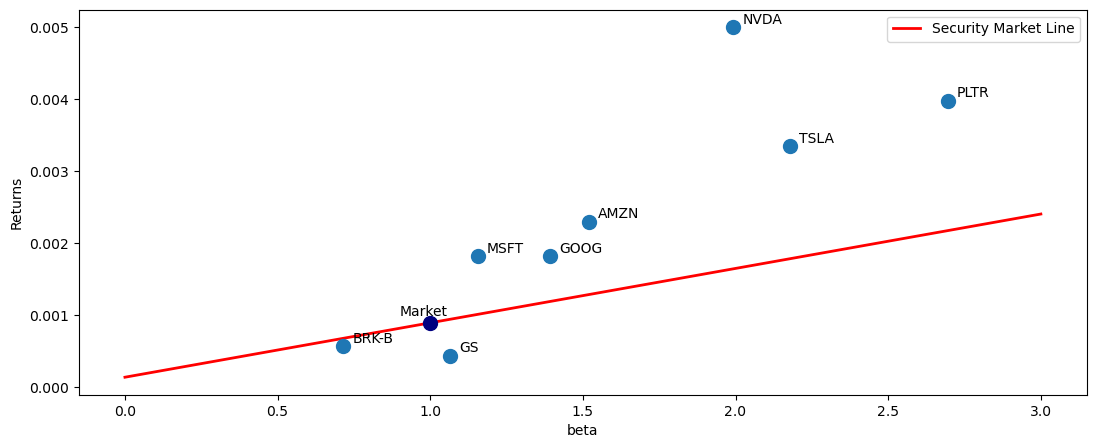

In [195]:
market_returns = get_mean_returns(R_M)

plt.figure(figsize = (13, 5))
    
security_market_line = lambda x : ( (market_returns - avg_daily_risk_free_rate) / 1.0) * x + avg_daily_risk_free_rate
xrange = np.linspace(0., 3, num=2)
plt.plot(xrange, [security_market_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

plt.plot(betas, returns, 'o', markersize = 10)
for idx in range(len(stocks)):
    plt.annotate(stocks[idx], xy=(betas[idx], returns[idx]),
        xytext=(betas[idx] + 0.03, returns[idx] + 0.00005))
plt.xlabel('beta')
plt.ylabel('Returns')

plt.plot([1], [market_returns], marker='o', color='navy', markersize=10)
plt.annotate('Market', xy=(1, market_returns), xytext=(0.9, market_returns+0.0001))

plt.legend(['Security Market Line']);

## Testing the CAPM for our Portfolio of stocks ##

Let's test how well the CAPM fits our Portfolio stocks. CAPM prediction:
$$ E\left(r \right) = r_F + \beta \times E\left( r_M - r_F \right) $$

By plotting this as a time series and as a regression plot we can see that the CAPM misses a lot of features, i.e. other factors seem to play an import role in the returns of our stock portfolios.

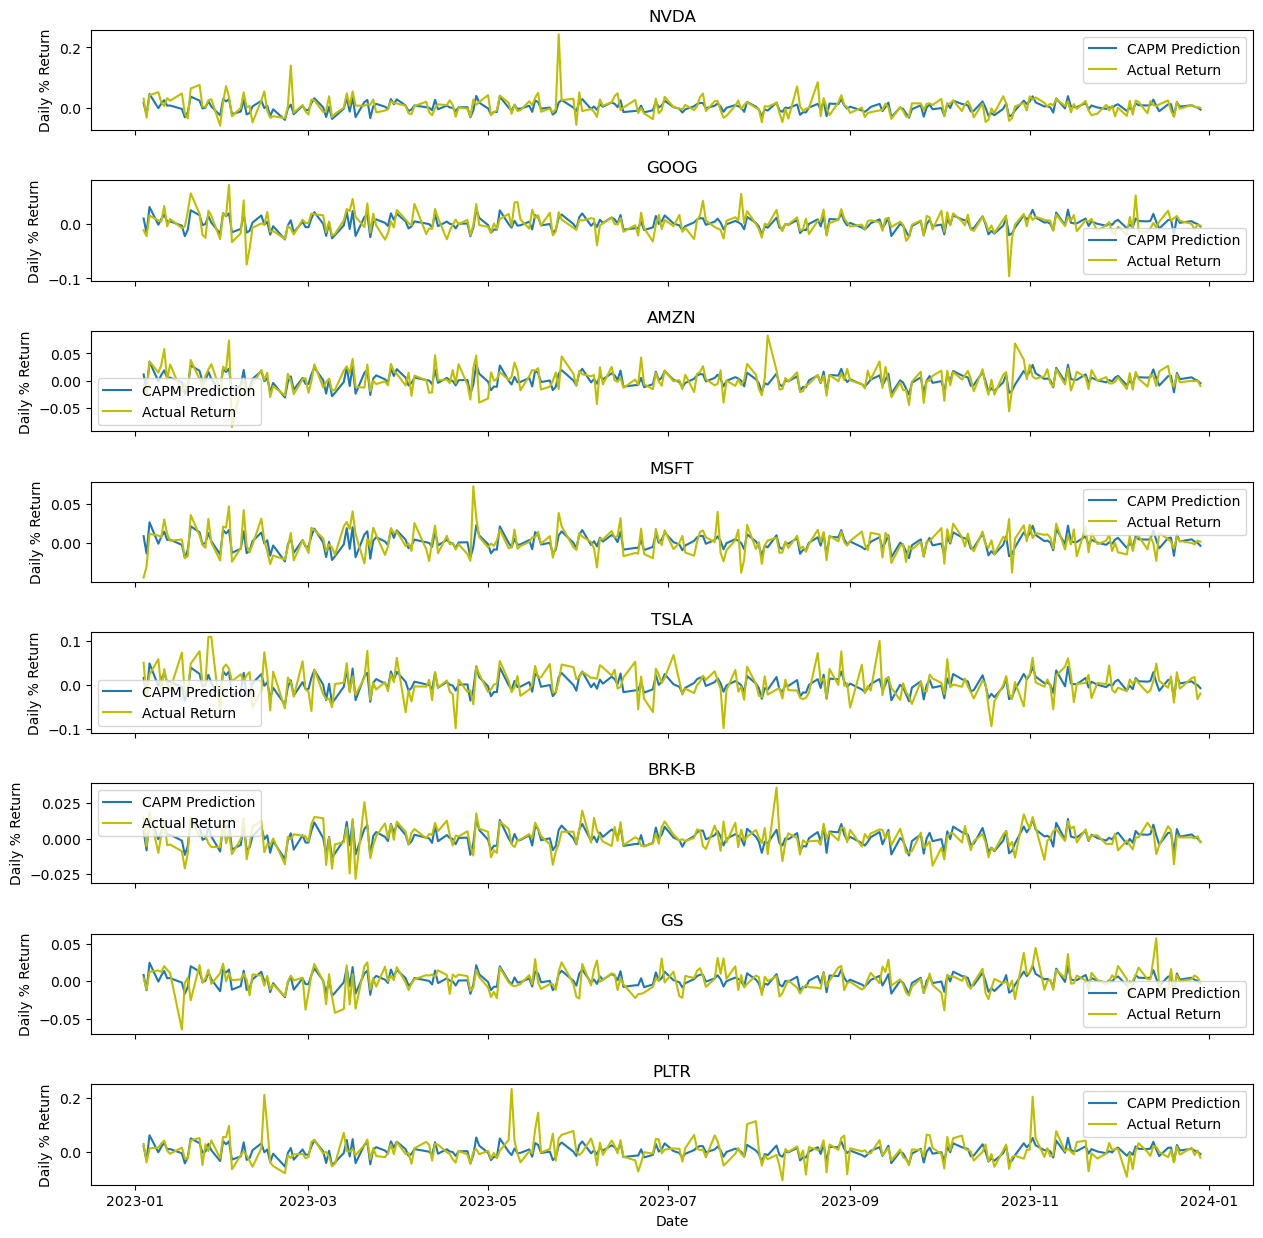

In [196]:
fig, axs = plt.subplots(len(stocks) ,sharex = True, figsize = (15,15))
plt.subplots_adjust(hspace = 0.5)
for idx, stock in enumerate(stocks):
    predictions = R_F + betas[idx]*(R_M - R_F) # expected return from CAPM

    axs[idx].plot(predictions)
    axs[idx].plot(R_stocks[stock], color = 'y')
    axs[idx].legend([f'CAPM Prediction', 'Actual Return'])
    axs[idx].set(ylabel = 'Daily % Return', title = stock)

plt.xlabel('Date');

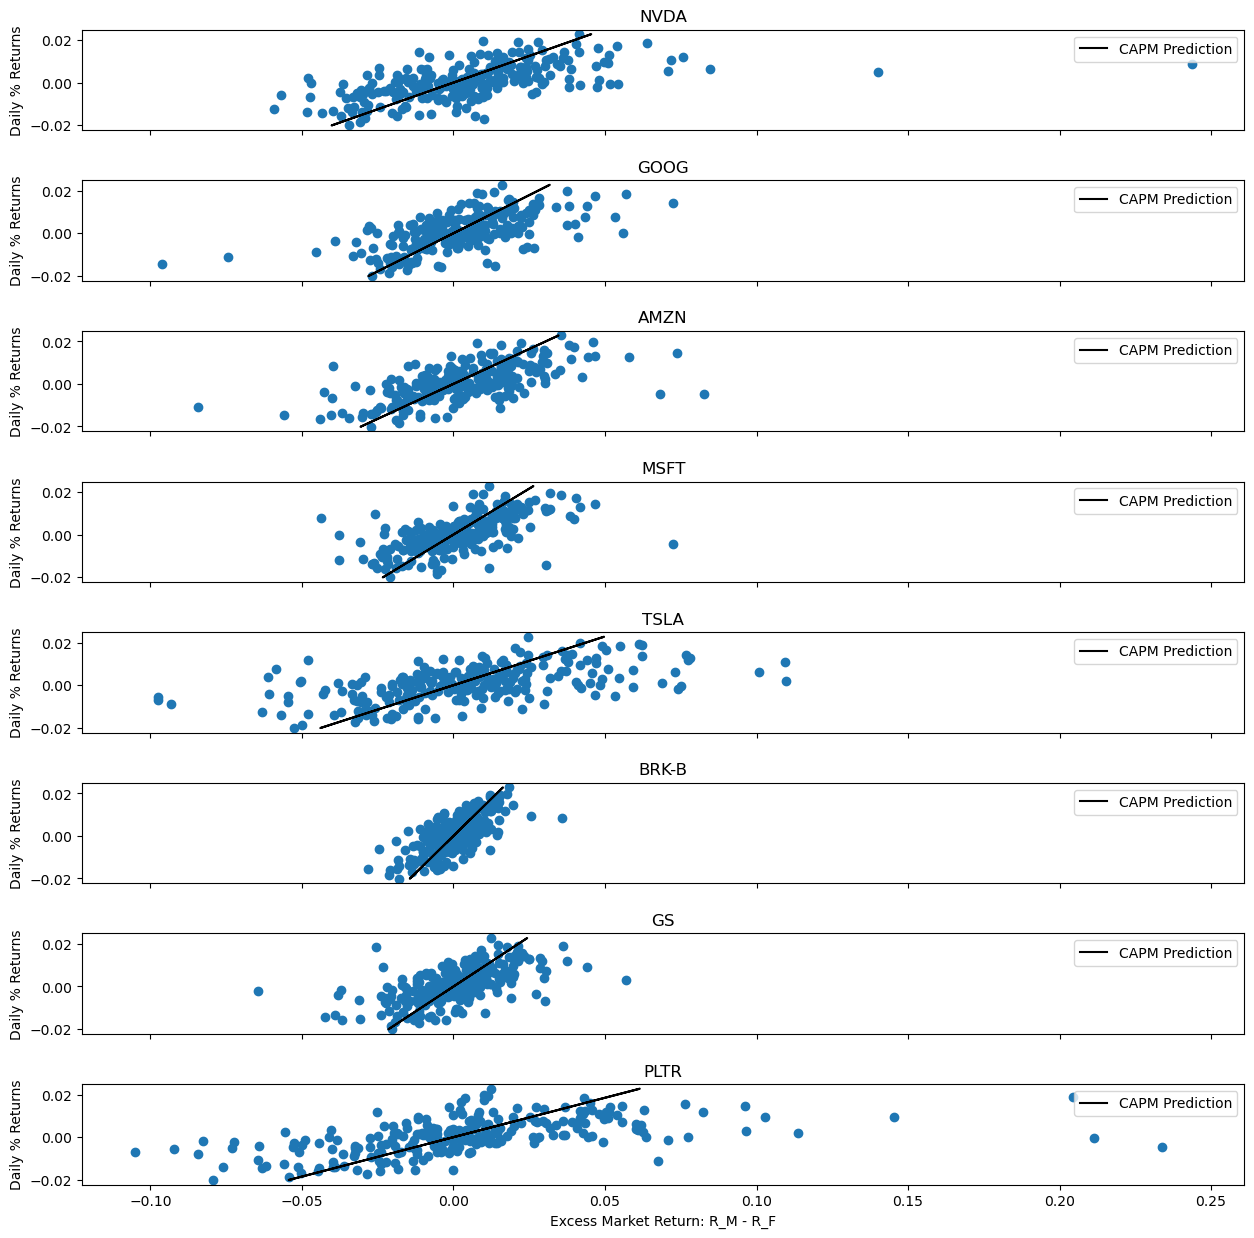

In [197]:
fig, axs = plt.subplots(len(stocks), sharex = True, figsize = (15,15))
plt.xlabel('Excess Market Return: R_M - R_F')
plt.subplots_adjust(hspace = 0.5)
for idx, stock in enumerate(stocks):
    predictions = betas[idx]* (R_M - R_F) # expected excess return from CAPM

    axs[idx].scatter(R_stocks[stock] - R_F, R_M - R_F, label = '_')
    axs[idx].plot(predictions, R_M - R_F, color = 'black', label = 'CAPM Prediction')
    axs[idx].set(ylabel = 'Daily % Returns', title = stock)
    axs[idx].legend()

# Construct optimal portfolio by minimising variance for given return #

In [219]:
def mean_returns_cov(stock_data):
    '''Compute mean returns and covariance matrix of stock portfolio'''
    returns = stock_data.pct_change()
    mean_returns = get_mean_returns(returns)
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

def portfolio_performance(weights, mean_returns, cov_matrix):
    '''Compute portfolio performance: return and volatility'''
    portfolio_return = np.dot(weights, mean_returns) * 252
    portfolio_vol = np.sqrt( np.dot(np.dot(weights.T, cov_matrix), weights) * 252 )
    return portfolio_return, portfolio_vol

def negative_SR(weights, mean_returns, cov_matrix, risk_free_rate = 0):
    '''Compute negative Sharpe Ratio'''
    p_returns, p_vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_vol

def maximise_SR(mean_returns, cov_matrix, risk_free_rate = 0, constraint_set = (0, 1)):
    'Minimise the negative Sharpe Ratio by altering the weights of portfolio'
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # require that each asset can only have weights between 0 and 1
    bound = constraint_set
    bounds = tuple(bound for asset in range(num_assets))
    # optimise by minimising the negative Sharpe Ratio, given an initial weight vector of 1 / num_assets for each asset
    result = sc.minimize(negative_SR, [ 1. / num_assets] * num_assets, args = args, \
                        method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

def portfolio_return(weights, mean_returns, cov_matrix):
    '''Compute portfolio returns'''
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_vol(weights, mean_returns, cov_matrix):
    '''Compute Portfolio volatility'''
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

def minimise_variance(mean_returns, cov_matrix, constraint_set = (0, 1)):
    'Minimise the portfolio variance by altering the weights in portfolio'
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraint_set
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sc.minimize(portfolio_vol, [1. / num_assets] * num_assets, args = args, \
                        method = 'SLSQP', bounds = bounds, constraints = constraints)
    
    return result

def print_portfolio_results(name, weights, excess_returns, vol, SR):
    '''Print Sharpe Ratio, Excess Returns, Volatility and Allocation'''
    print(name + ' Portfolio')
    print(f'Sharpe Ratio: {SR:.2}')
    print(f'Excess Returns: {round(100*excess_returns, 2)}%')
    print(f'Volatility: {round(100*vol,2)}%')
    print('Allocation:')
    for idx in range(len(stocks)):
        print(f'{stocks[idx]}: {round(100*weights[idx])}%')
        
def efficient_portfolio(mean_returns, cov_matrix, return_target, risk_free_rate = 0, constraint_set = (0, 1)):
    '''For each return target, optimise the portfolio for min volatility'''
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns, cov_matrix) \
                    - risk_free_rate - return_target}, \
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(constraint_set for asset in range(num_assets))
    eff_portfolio = sc.minimize(portfolio_vol, [1. / num_assets] * num_assets, args = args, \
                        method = 'SLSQP', bounds = bounds, constraints = constraints)
    return eff_portfolio
        
def calc_efficient_frontier(mean_returns, cov_matrix, risk_free_rate = 0, constraint_set = (0, 1)):
    '''Calculate the Max SR, Min Vol and Efficient Frontier portfolios'''
    
    # Max SR Portfolio
    max_SR_portfolio = maximise_SR(mean_returns, cov_matrix, risk_free_rate)
    max_SR_returns, max_SR_vol = portfolio_performance(max_SR_portfolio['x'], mean_returns, cov_matrix)
    max_SR_excess_returns = max_SR_returns - risk_free_rate
    max_SR_allocation = pd.DataFrame(max_SR_portfolio['x'], index = mean_returns.index, columns = ['Allocation'])
    max_SR_allocation.Allocation = [round(100*allocation, 1) for allocation in max_SR_allocation.Allocation]
    
    # Min Vol Portfolio
    min_vol_portfolio = minimise_variance(mean_returns, cov_matrix)
    min_vol_returns, min_vol = portfolio_performance(min_vol_portfolio['x'], mean_returns, cov_matrix)
    min_vol_excess_returns = min_vol_returns - risk_free_rate
    min_vol_allocation = pd.DataFrame(min_vol_portfolio['x'], index = mean_returns.index, columns = ['Allocation'])
    min_vol_allocation.Allocation = [round(100*allocation, 1) for allocation in min_vol_allocation.Allocation]
    
    target_returns = np.linspace(min_vol_excess_returns, max_SR_excess_returns, 20)
    efficient_frontier_vols = []
    for target in target_returns:
        # for each efficient portfolio, obtain the portfolio volatility
        efficient_frontier_vols.append(efficient_portfolio(mean_returns, cov_matrix, target, risk_free_rate)['fun'])
        
    max_SR_excess_returns, max_SR_vol = round(100*max_SR_excess_returns,2), round(100*max_SR_vol,2)
    min_vol_excess_returns, min_vol = round(100*min_vol_excess_returns,2), round(100*min_vol,2)
    
    return max_SR_excess_returns, max_SR_vol, max_SR_allocation, min_vol_excess_returns, min_vol, \
    min_vol_allocation, efficient_frontier_vols, target_returns

def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate = 0, constraint_set = (0, 1)):
    '''Return a graph plotting min vol, max SR and efficient frontier'''
    max_SR_excess_returns, max_SR_vol, max_SR_allocation, min_vol_excess_returns, \
    min_vol, min_vol_allocation, efficient_frontier_vols, target_returns = calc_efficient_frontier(mean_returns, cov_matrix)
    
    # Max Sharpe Ratio
    max_SR = go.Scatter(name = 'Maximum Sharpe Ratio',
                       mode = 'markers',
                       x = [max_SR_vol],
                       y = [max_SR_excess_returns],
                       marker = dict(color = 'red', size = 14, line = dict(width = 3, color = 'black')))
    
    # Min Vol Portfolio
    min_vol = go.Scatter(name = 'Minimum Volatility',
                       mode = 'markers',
                       x = [min_vol],
                       y = [min_vol_excess_returns],
                       marker = dict(color = 'green', size = 14, line = dict(width = 3, color = 'black')))
    
    # Efficient Frontier
    ef_curve = go.Scatter(name = 'Efficient Frontier',
                       mode = 'lines',
                       x = [round(ef_vol*100, 2) for ef_vol in efficient_frontier_vols],
                       y = [round(target*100,2) for target in target_returns],
                       line = dict(color = 'black', width = 4, dash = 'dashdot'))
    
    data = [max_SR, min_vol, ef_curve]
    
    layout = go.Layout(title = 'Portfolio Optimisation with Efficient Frontier',
                      yaxis = dict(title = 'Annualised Excess Returns (%)'),
                      xaxis = dict(title ='Annualised Volatility (%)'),
                      showlegend = True,
                      legend = dict(x = 0.75, y = 0, traceorder = 'normal',
                                   bgcolor = '#E2E2E2', bordercolor = 'black',
                                   borderwidth = 2),
                      width = 800,
                      height = 600)
    
    fig = go.Figure(data = data, layout = layout)
    
    return fig.show()

Plot the Efficient Frontier for our portfolio stocks

In [220]:
plot_efficient_frontier(mean_returns, cov_matrix, avg_annual_risk_free_rate)

### Study a random, Max Sharpe Ratio and Min Volatility Portfolios ###

In [201]:
mean_returns, cov_matrix = mean_returns_cov(prices_df[stocks])

In [212]:
max_SR_result = maximise_SR(mean_returns, cov_matrix, avg_annual_risk_free_rate)
max_SR, max_SR_weights = -max_SR_result['fun'], max_SR_result['x']
max_SR_returns, max_SR_vol = portfolio_performance(max_SR_weights, mean_returns, cov_matrix)
max_SR_excess_returns = max_SR_returns - avg_annual_risk_free_rate
print_portfolio_results('Maximal Sharpe Ratio', max_SR_weights, max_SR_excess_returns, max_SR_vol, max_SR)

Maximal Sharpe Ratio Portfolio
Sharpe Ratio: 2.6
Excess Returns: 97.86%
Volatility: 37.32%
Allocation:
NVDA: 60%
GOOG: 0%
AMZN: 26%
MSFT: 0%
TSLA: 10%
BRK-B: 0%
GS: 0%
PLTR: 4%


In [213]:
min_var_result = minimise_variance(mean_returns, cov_matrix)
min_var, min_var_weights = min_var_result['fun'], min_var_result['x']
min_var_returns, min_var_vol = portfolio_performance(min_var_weights, mean_returns, cov_matrix)
min_var_excess_returns = min_var_returns - avg_annual_risk_free_rate
print_portfolio_results('Minimal Variance', min_var_weights, min_var_excess_returns, min_var_vol, min_var)

Minimal Variance Portfolio
Sharpe Ratio: 0.13
Excess Returns: 14.18%
Volatility: 13.0%
Allocation:
NVDA: 0%
GOOG: 0%
AMZN: 0%
MSFT: 16%
TSLA: 0%
BRK-B: 81%
GS: 2%
PLTR: 0%


Create random portfolio

In [214]:
np.random.seed(123)

def random_assets(n_assets = 7, n_obs = 2_000):
    '''Generate a set of n_asset assets and n_obs data points with random returns
    Useful if we want to study some random assets, as opposed to real ones'''
    rand_return_vec = np.random.randn(n_assets, n_obs)
    rand_mean_returns = np.mean(rand_return_vec, axis = 1)
    rand_mean_returns = pd.Series(rand_mean_returns, index = [i for i in range(len(rand_mean_returns))])
    rand_cov_matrix = np.cov(rand_return_vec)
    return rand_mean_returns, rand_cov_matrix

def random_weights(num_assets):
    '''Produce n random weights that sum to 1'''
    k = np.random.rand(num_assets)
    return k / sum(k)

def random_portfolio(mean_returns, cov_matrix):
    '''Return mean and volatility of returns for a random portfolio'''
    weights = random_weights(len(mean_returns))

    returns, vol = portfolio_performance(weights, mean_returns, cov_matrix)

    return returns, vol

A random portfolio:

In [215]:
weights = random_weights(len(mean_returns))
p_returns, p_vol = portfolio_performance(weights, mean_returns, cov_matrix)
p_SR = - negative_SR(weights, mean_returns, cov_matrix, avg_annual_risk_free_rate)
p_excess_returns = p_returns - avg_annual_risk_free_rate
print_portfolio_results('Sample', weights, p_excess_returns, p_vol, p_SR)

Sample Portfolio
Sharpe Ratio: 2.2
Excess Returns: 57.38%
Volatility: 26.67%
Allocation:
NVDA: 15%
GOOG: 6%
AMZN: 5%
MSFT: 12%
TSLA: 16%
BRK-B: 9%
GS: 21%
PLTR: 15%


### Simulate random portfolios of these stocks ###

All these will lie underneath the Efficient Frontier

In [217]:
n_portfolios = 10_000

all_portfolios = []
for portfolio in range(n_portfolios):
    clear_output(wait = True)
    print(f'Creating random portfolio {portfolio + 1} of {n_portfolios}')
    all_portfolios.append(random_portfolio(mean_returns, cov_matrix))

returns, vols = np.column_stack(all_portfolios)
returns = returns - avg_annual_risk_free_rate

Creating random portfolio 10000 of 10000


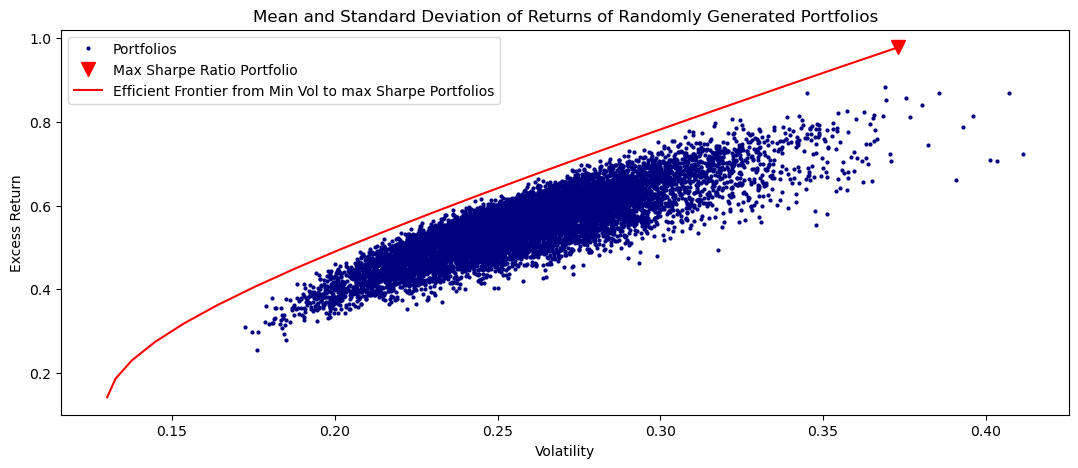

In [221]:
result = calc_efficient_frontier(mean_returns, cov_matrix, avg_annual_risk_free_rate)
eff_vols = result[-2]
eff_excess_returns = result[-1]

plt.figure(figsize = (13, 5) )
plt.plot(vols, returns, 'o', markersize = 2, color = 'navy')
plt.xlabel('Volatility')
plt.ylabel('Excess Return')
plt.title('Mean and Standard Deviation of Returns of Randomly Generated Portfolios')

plt.plot(max_SR_vol, max_SR_excess_returns, 'v', markersize = 10, color = 'red')

plt.plot(eff_vols, eff_excess_returns, '-', markersize = 3, color = 'red')
plt.legend(['Portfolios', 'Max Sharpe Ratio Portfolio', 'Efficient Frontier from Min Vol to max Sharpe Portfolios']);